# CWE Foamtree Visualization

There are four main tables in the XML. They are **Views**, **Categories**, **Weaknesses**, and **Coumpound_Elements**. In the XML, the contents of these main categories are messy, however, on the website these main tables mostly follow the below hierarchy. The four main fields contain the entries related to that category. The hierarchy functions are explained in detail in [CWE Introduction](https://github.com/sailuh/perceive/blob/master/Notebooks/CWE/cwe_introduction.ipynb).

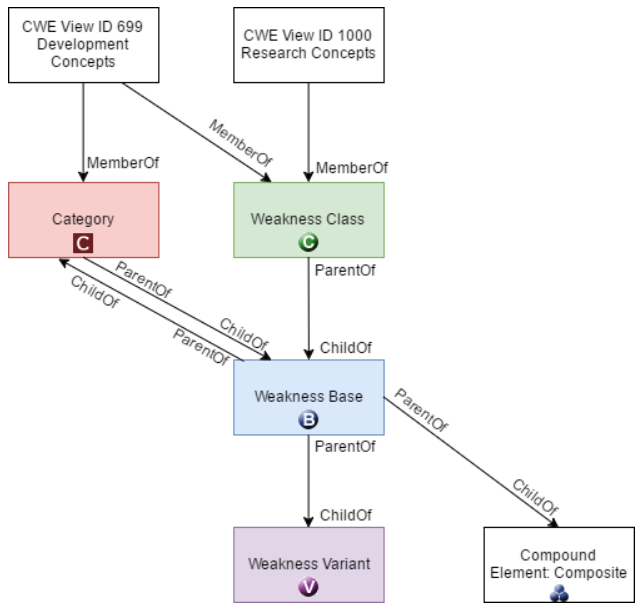

In [1]:
from IPython.display import Image
Image(filename='img/types_of_nodes_and_their_relationships_in_CWE.PNG')

The following code creates a foamtree visualization from cwe version 2.2 to cwe version 2.12, except for cwe version 2.11. It is currently being tested for other versions. 

In [2]:
import csv
import json
import xml.etree.ElementTree as ET
import sys
import os
import argparse

parser = argparse.ArgumentParser(description = 'CWE XML visualisation program.')
parser.add_argument('xml_filepath', help = 'path of the cwe xml file')
parser.add_argument('javascript_filepath', help = 'path of the carrotsearch.foamtree.js file')
parser.add_argument("--json", help = "export .json file", action = "store_true")
parser.add_argument("--gephi", help = "export node and edge table for gephi visualisation", action = "store_true")
args = parser.parse_args()   

usage: ipykernel_launcher.py [-h] [--json] [--gephi]
                             xml_filepath javascript_filepath
ipykernel_launcher.py: error: the following arguments are required: javascript_filepath


SystemExit: 2

C:\Users\Vaish\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2870: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [9]:
filepath = args.xml_filepath
javascript_path = args.javascript_filepath

"""Obtaining the CWE xml filename from the path"""
CWE_xml = filepath.split(os.sep)[-1]

"""This is the inline data model.
   This contains CWE_ID, CWE_NAME and CHILD_OF nodes.
   This can be extended to have more details.
"""
CWE_version = CWE_xml[:-4]
CWE_json = CWE_version + ".json"
CWE_html = CWE_version + ".html"
CWE_csv_edgelist = CWE_version + " [Edges].csv"
CWE_csv_nodelist = CWE_version + " [Nodes].csv"
 
CWE_entries = list()

CWE_tree = ET.parse(filepath)
CWE_root = CWE_tree.getroot()

"""The purpose of this function is to remove the commas in the string that is passed as input. 
   The need is that some of the CWE names contain commas and when eventually added to a CSV file, they occupy multiple 
   cells instead of just one. In order to overcome that we pass the CWE name and obtain the "comma-less" version of it.
"""

def remove_commas(string):
    comma_free_string = ''
    temp_string = string.split(',')
    for i in temp_string:
        comma_free_string+=i
    return comma_free_string                       

NameError: name 'args' is not defined

In [10]:
"""There are currently 2 for loops which write to the data model.
   
   The first one is used to write the weaknesses with parent as 1000 - Research Concepts
   CWE_root[0][0] is used to obtain cwe:Views and then under it the first tag that contains Research Concepts and its Weakness Classes
   
   After obtaining the cawe_id, we search for the name in the cwe:Weakness which is CWE_root[2] 
"""
for views in CWE_root[0][0]:
    for members in views:                                                
        if members.tag=="Relationship":  
            cwe_id = members[3].text
            child_of = '1000'
            for weakness in CWE_root[2]:
                if weakness.attrib['ID']==cwe_id:
                    cwe_name = remove_commas(weakness.attrib['Name'])
                    temp_list = list()
                    temp_list.extend((cwe_id,cwe_name,child_of))
                    CWE_entries.append(temp_list)

NameError: name 'CWE_root' is not defined

In [2]:
"""This is used to write the Weaknesses onto the data model
   CWE_root[2] is used to obtain the cwe:Weakness tag.
   
   related_weakness_parameter[2] is cwe:Relationship_Nature
"""

for weakness in CWE_root[2]:
     if weakness.attrib['Status']!="Deprecated":
        for parameter in weakness:
            if parameter.tag=="Relationships":
                for related_weakness_parameter in parameter:
                    if related_weakness_parameter[2].text == "ChildOf":    
                        cwe_id= weakness.attrib['ID']
                        cwe_name= remove_commas(weakness.attrib['Name'])
                        child_of= related_weakness_parameter[3].text
                        temp_list = list()
                        temp_list.extend((cwe_id,cwe_name,child_of))
                        CWE_entries.append(temp_list)
                       

NameError: name 'CWE_root' is not defined

In [1]:
"""This is used to write the Compound Elements onto the data model
   CWE_root[3] is used to obtain the cwe:Compound_Elements tag.
"""

for comp_element in CWE_root[3]:
     if comp_element.attrib['Status']!="Deprecated":
        for parameter in comp_element:
            if parameter.tag=="Relationships":
                for relationship_parameter in parameter:
                    if relationship_parameter[2].text == "ChildOf":    
                        cwe_id= comp_element.attrib['ID']
                        cwe_name= remove_commas(comp_element.attrib['Name'])
                        child_of= relationship_parameter[3].text
                        temp_list = list()
                        temp_list.extend((cwe_id,cwe_name,child_of))
                        CWE_entries.append(temp_list)
                        print(cwe_id)
                    

NameError: name 'CWE_root' is not defined

In [1]:
""" The Foamtree Visualization """
def jsonify(number):
    main_list = list()
    for row in CWE_entries:
        parent_id = str(number)
        if row[2]==parent_id:
            member_dict = dict()
            member_dict["label"] = str(row[0]) + ' - ' + str(row[1])
            member_dict["weight"] = 1
            member_dict["groups"] = jsonify(row[0])
            main_list.append(member_dict)
        else:
            continue
    return main_list

def gephi_export(number): 
    fe = open(CWE_csv_edgelist, 'w')
    HEADe = "Source,Target,Type,id,label,timeset,weight\n"
    fe.write(HEADe)
    
    fn = open(CWE_csv_nodelist, 'w')
    HEADn = "Id,Label,timeset\n"
    fn.write(HEADn)

    cweid_id_dict = dict()
    cwecid_id_dict[str(number)]='0'
    node = '{o1},{o2},{o3}\n'.format(o1='0',o2=number,o3='')
    fn.write(node)
    id_counter = 1
    for row in CWE_entries:
        node = '{o1},{o2},{o3}\n'.format(o1=id_counter,o2=row[0],o3='')
        fn.write(node)
        cweid_id_dict[row[0]]=id_counter
        id_counter+=1

    type_value = "Directed"
    edge_id_counter = 0
    for row in CWE_entries:
        if row[2] in cweid_id_dict:
            source_value = int(cweid_id_dict[row[2]])
            target_value = int(cweid_id_dict[row[0]])
            edge = '{o1},{o2},{o3},{o4},{o5},{o6},{o7}\n'.format(o1=source_value,o2=target_value,o3=type_value,o4=edge_id_counter,o5='',o6='',o7=1)
            fe.write(edge)
            edge_id_counter+=1
            
def createJSON():
    with open(CWE_json,'w') as jsonfile:
        json.dump(CWE_dict, jsonfile)
    jsonfile.close()
    
            
def createHTML():
    foamtreetemplate1 = '''<!DOCTYPE html>
    <html>
      <head>
        <title>FoamTree Quick Start</title>
        <meta charset="utf-8" />
      </head>

      <body>
        <div id="visualization" style="width: 800px; height: 600px"></div>

        <script src="'''+ javascript_path +'''"></script>
        <script>
          window.addEventListener("load", function() {
            var foamtree = new CarrotSearchFoamTree({
              id: "visualization",
              dataObject:'''

    foamtreetemplate2 = '''});
          });
        </script>
      </body>
    </html>'''

    with open(CWE_html,'w') as outputfile:
        outputfile.write(foamtreetemplate1)
        for line in open(CWE_json):
            outputfile.write(line)
        outputfile.write(foamtreetemplate2)

CWE_dict = dict()
CWE_dict["groups"]=jsonify(1000)
createJSON()
createHTML()

if args.gephi:
    gephi_export(1000)

if args.json == False:
    os.remove(CWE_json)



NameError: name 'CWE_entries' is not defined

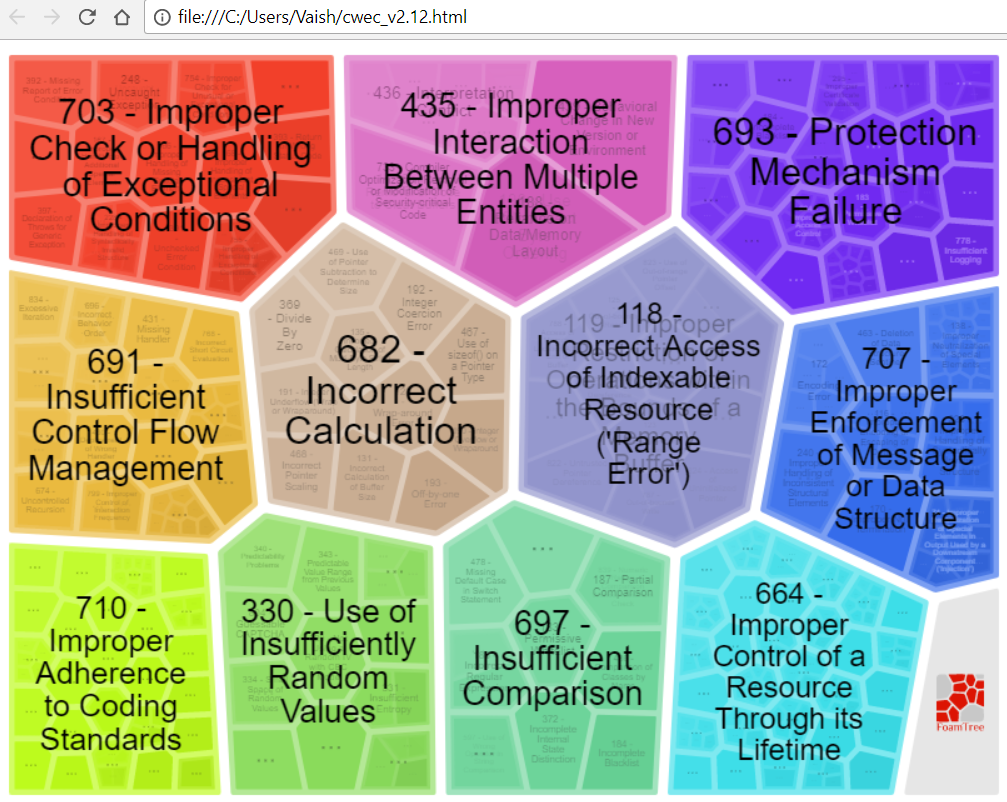

In [3]:
from IPython.display import Image
Image(filename='cwe2.12_snapshot1.PNG')

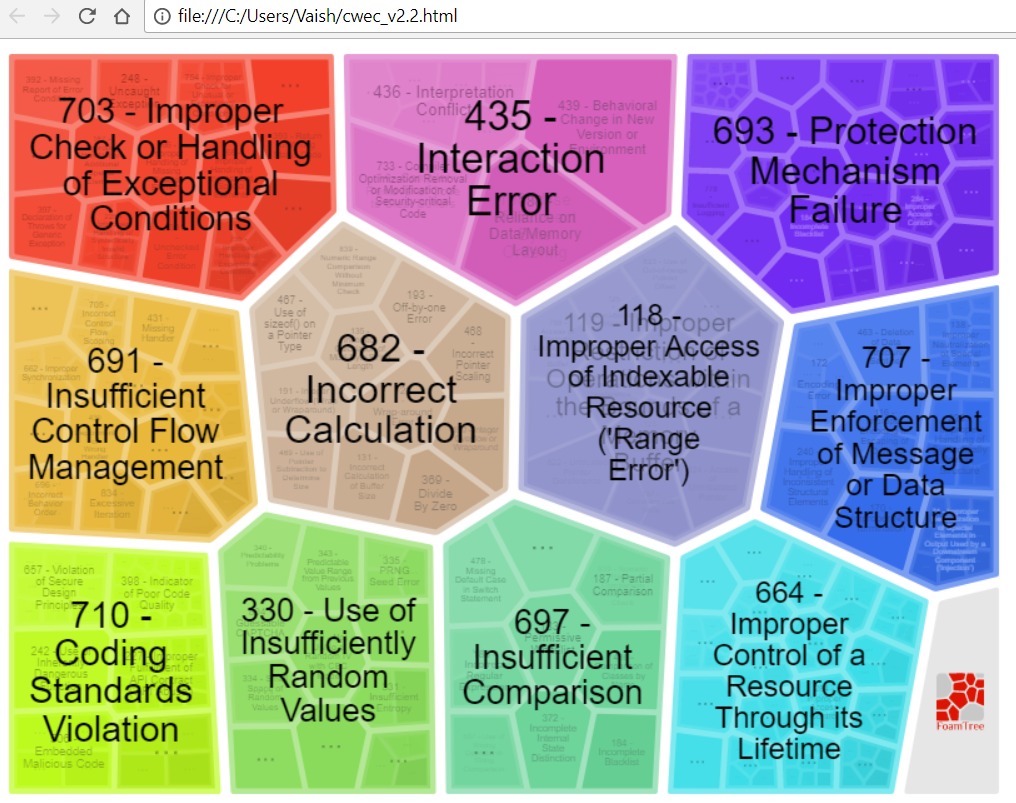

In [4]:
from IPython.display import Image
Image(filename='cwe2.2_snapshot1.PNG')

The below displays a sample of the visualization created from the code for the CWE versions mentioned above:

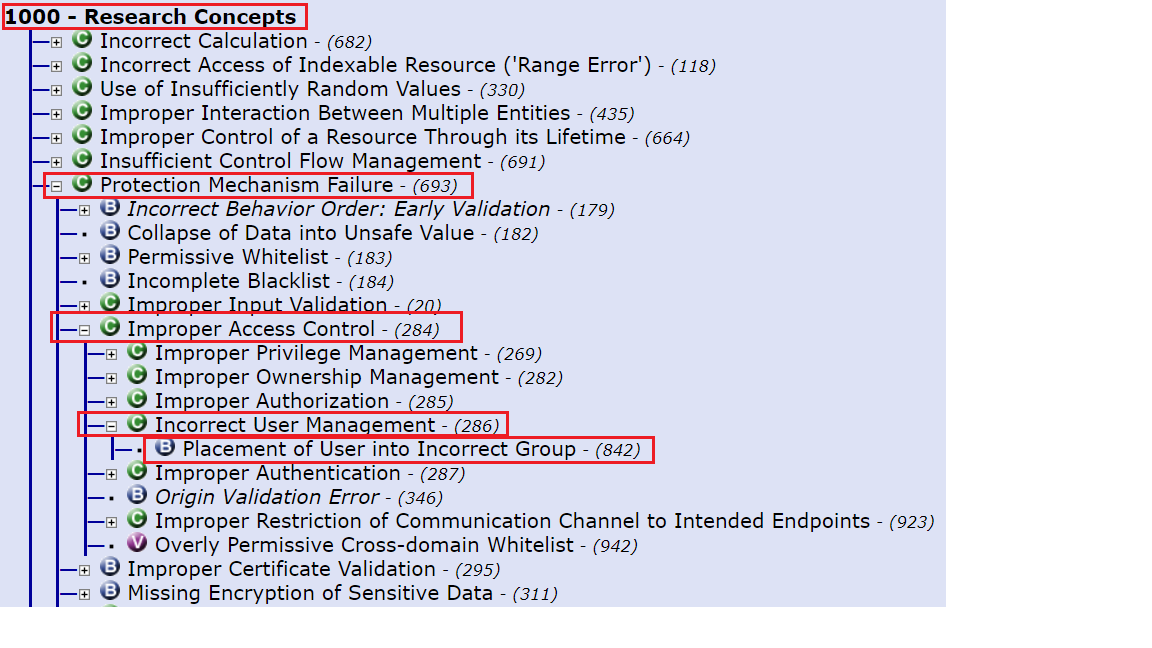

In [9]:
from IPython.display import Image
Image(filename='cwewebsite_reference.PNG')

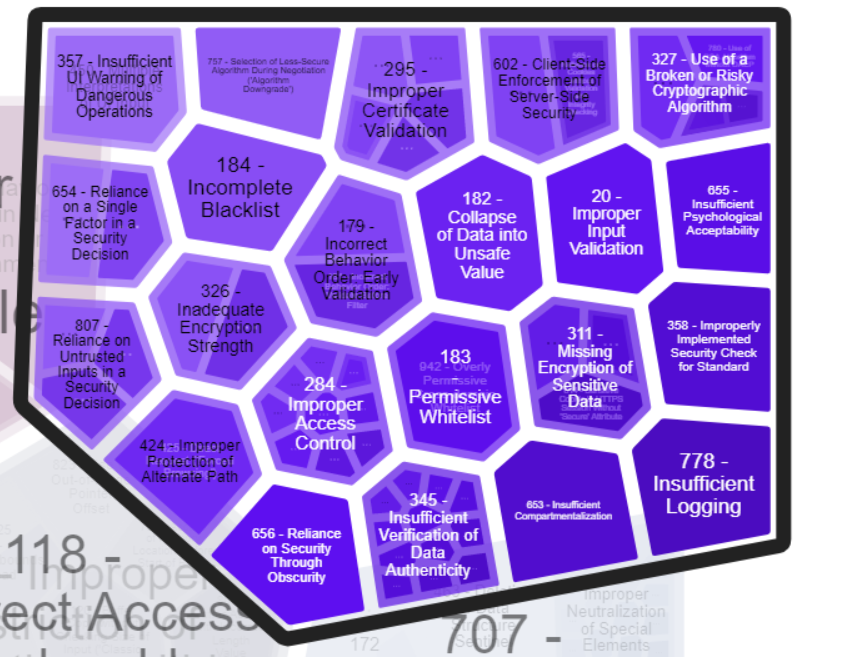

In [5]:
from IPython.display import Image
Image(filename='snapshot2_cwe 693.PNG')

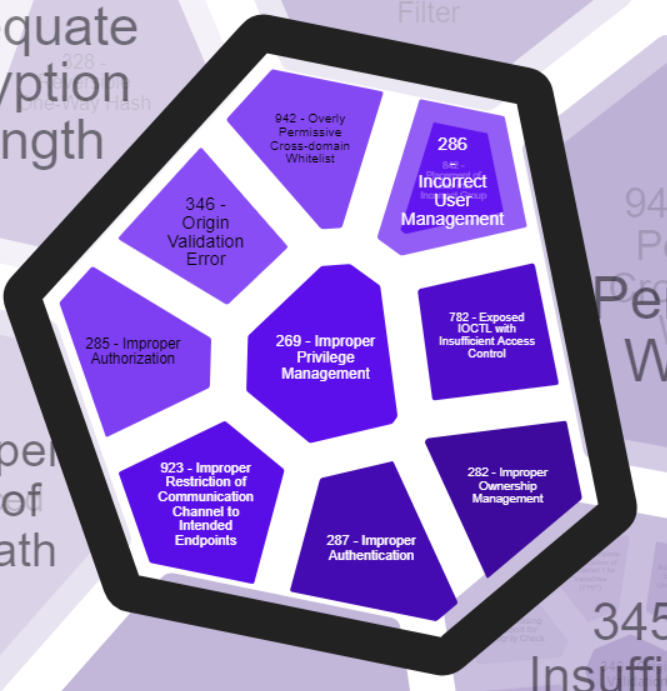

In [6]:
from IPython.display import Image
Image(filename='snapshot3_cwe 284.PNG')

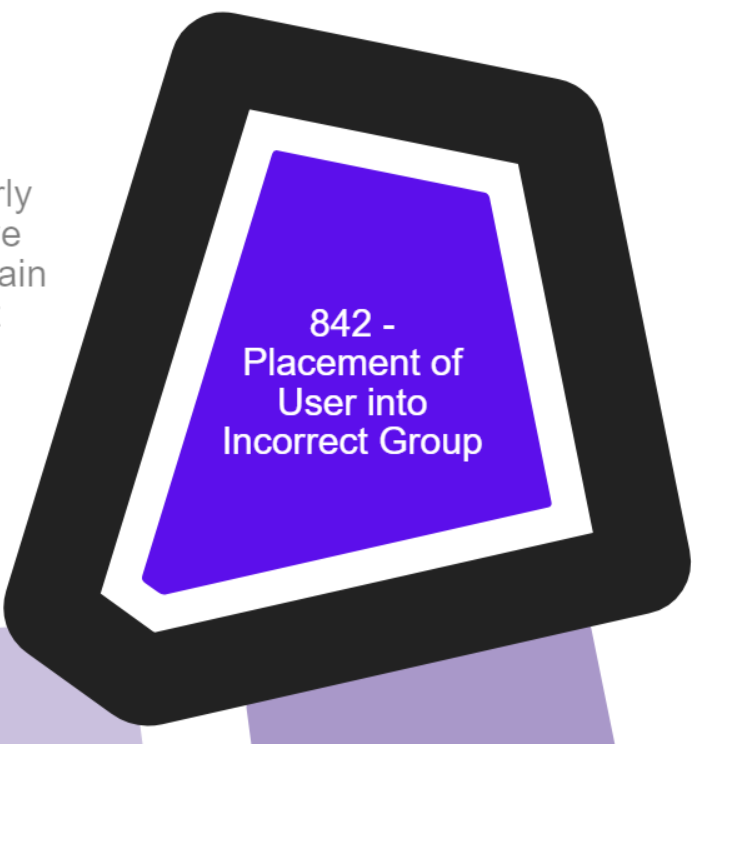

In [7]:
from IPython.display import Image
Image(filename='snapshot4_cwe 286.PNG')